## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import moment
from collections import deque

# Pytorch
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sklearn
from sklearn.metrics import mean_squared_error
import math
import plotly.express as px
import os
os.chdir("/home/rodrigo/mount/home/rodrigo/git/neural_kaggle_store_item")

import time
import math
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from transformer.model import TransformerTimeSeries
from transformer.utils import TransformerTimeSet, batch_train, batch_val
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
np.random.seed(0)


## Generate train and test sets
For a simple example lets generate sinusoid data to test with

In [2]:
data_train = pd.read_csv('train_series.csv')
data_train = data_train['data'].to_numpy()

data_val = pd.read_csv('val_series.csv')
data_val = data_val['data'].to_numpy()

total_train = len(data_train)

data_test = pd.read_csv('test_series.csv')
data_test = data_test['data'].to_numpy()

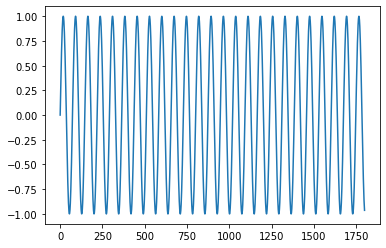

In [3]:
plt.plot(data_train)

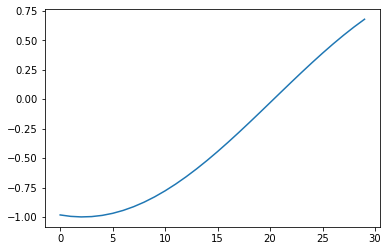

In [40]:
plt.plot(data_test)

## Using Neural networks for solving the time series problem
First, it is necessary to transform this time series problem into a supervised learning problem; for this, it is necessary to define whether the network will make a recursive forecast, in which the forecasts will be used as resources for a longer time horizon or if the network will make a direct forecast, in which the network only uses the last steps of time and resources known as the day of the week, to forecast several steps.

### Direct prediction approach
To predict the 3 months of sales is necessary to define first the labels and features of the model, as features the model will use 3 months of past sales data and the 3 months of weekdays value. As labels would be 3 months of the future data, to extrat the labels and features of the data a rolling window approach is reaquired, this way a window of 3 months past data, 3 months of weekdays value could be related to 3 months of future data

## Rolling window approach

With this approach is possible to turn a series of data into a supervised learning problem, this way the model can intepretate the problem properly.

In [4]:
#Scaling the entry data
data_train   = data_train.reshape(-1,1)
scaler        = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train   = scaler.transform(data_train).flatten()


# data_val = scaler.transform(data_val.reshape(-1,1)).flatten()
index_val     = np.arange(len(data_train))

# Three months of prediction
pred_horizon = 30
label_win = 30
feat_win  = 30
win_size  = label_win + feat_win 
n_windows = total_train - win_size

In [5]:
def rolling_window(n_windows, feat_win, label_win, dataset):
    # encoder and decoder vectors
    x_encoder = np.zeros((n_windows, int(feat_win)))
    x_decoder = np.zeros((n_windows, int(label_win)))
    x_id_encoder = np.zeros((n_windows, int(feat_win)))
    x_id_decoder = np.zeros((n_windows, int(label_win)))

    # output
    y_train = np.zeros((n_windows, label_win))
    y_id = np.zeros((n_windows, label_win))
    for win in range(n_windows):
        # Feature window start and end index
        i_s_feat = win
        i_e_feat = i_s_feat + feat_win

        # Label window start and end index
        i_s_label = i_e_feat
        i_e_label = i_s_label + label_win

        # Geting the past sales feature
        x_encoder[win] = dataset[i_s_feat : i_e_feat]
        x_id_encoder[win] = index_val[i_s_feat : i_e_feat]

        # Treat the decoder as autoregressive
        # and use lagged labels in the training and predictions in test
        x_decoder[win] = data_train[i_s_label - 1: i_e_label - 1]
        x_id_decoder[win] = index_val[i_s_label - 1: i_e_label - 1]

        # Geting the labels
        y_train[win] = data_train[i_s_label : i_e_label]
        y_id[win] = index_val[i_s_label : i_e_label]
        
    return x_encoder, x_decoder, x_id_encoder, x_id_decoder , y_train, y_id

In [6]:
x_encoder, x_decoder, x_id_encoder, x_id_decoder , y_train, y_id = rolling_window(n_windows, feat_win, 
                                                                  label_win, data_train)

n_val_windows = len(data_val) - win_size
x_val_encoder, x_val_decoder, _, _ , y_val, _ = rolling_window(n_val_windows, feat_win, 
                                                                  label_win, data_val)

In [7]:
y_id[0]

array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59.])

In [8]:
x_id_encoder[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [9]:
x_id_decoder[0]

array([29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
       55., 56., 57., 58.])

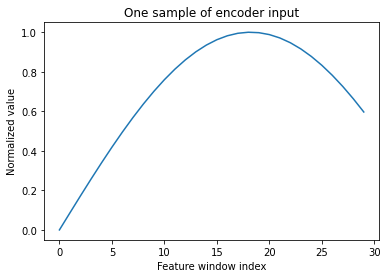

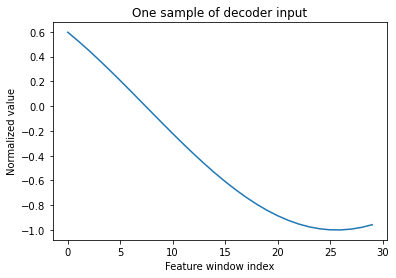

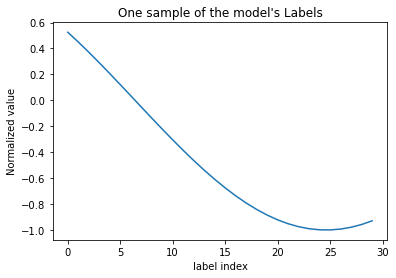

In [10]:
plt.plot(x_encoder[0], label='encoder input')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of encoder input")
plt.show()

plt.plot(x_decoder[0], label='decoder input')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of decoder input")
plt.show()

plt.plot(y_train[0], label='labels')
plt.ylabel('Normalized value')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()


## Defining the model
The recommended neural network for a time series problem usualy is a LSTM, in this example peharps we will use a simple multi layer perceptron (MLP) model.

## Transformer network

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = TransformerTimeSeries(device,  dropout=0, d_model=100, nhead=1, 
                              decoder_mask=True, 
                              n_encoder_time_steps=feat_win,
                              n_output_time_steps=label_win,
                              n_enc_layers=1,
                             ).to(device)

criterion = nn.MSELoss()
lr = 0.0005
batch_size= 120
epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

Using device: cuda


In [12]:
train_set = TransformerTimeSet(x_encoder, x_decoder, y_train, feat_win, label_win)
train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=True)

val_set = TransformerTimeSet(x_val_encoder, x_val_decoder, y_val, feat_win, label_win)
val_loader = DataLoader(val_set,
                          batch_size=batch_size,
                          shuffle=True)

In [13]:
loss = []
val_loss = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    val_epoch_loss = batch_val(model, val_loader, criterion, device)
    epoch_loss = batch_train(model, epoch, batch_size, train_loader, criterion, optimizer, scheduler,  y_train.shape[0], device)
    loss.append(epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     2/   14 batches | lr 0.000500 | 206.02 ms | loss 0.86333
| epoch   1 |     4/   14 batches | lr 0.000500 | 115.53 ms | loss 0.41655
| epoch   1 |     6/   14 batches | lr 0.000500 | 95.68 ms | loss 0.10818
| epoch   1 |     8/   14 batches | lr 0.000500 | 77.26 ms | loss 0.19961
| epoch   1 |    10/   14 batches | lr 0.000500 | 91.59 ms | loss 0.03338
| epoch   1 |    12/   14 batches | lr 0.000500 | 99.53 ms | loss 0.11443
| epoch   1 |    14/   14 batches | lr 0.000500 | 61.18 ms | loss 0.08144
| epoch   2 |     2/   14 batches | lr 0.000480 | 134.17 ms | loss 0.03792
| epoch   2 |     4/   14 batches | lr 0.000480 | 114.76 ms | loss 0.05968
| epoch   2 |     6/   14 batches | lr 0.000480 | 119.86 ms | loss 0.02147
| epoch   2 |     8/   14 batches | lr 0.000480 | 98.83 ms | loss 0.01353
| epoch   2 |    10/   14 batches | lr 0.000480 | 94.82 ms | loss 0.03299
| epoch   2 |    12/   14 batches | lr 0.000480 | 97.22 ms | loss 0.01890
| epoch   2 |    14/   14 batches

In [14]:
plot_df ={'epoch': np.arange(epoch),
          'train_loss': loss,
          'val_loss': val_loss,}

fig = px.line(plot_df, x='epoch', y=['train_loss', 'val_loss'])
fig.show()

## Testing iteratively

### Third test: Test with encoder vector full and decoder vector with only one sample

In [15]:
data_test   = data_test.reshape(-1,1)
data_test   = scaler.transform(data_test).flatten()

encoder_test = np.zeros(int(feat_win))
encoder_test = data_val[-feat_win:]

decoder_test = np.ones(int(label_win))
decoder_test[0] = data_val[-1]

label_test = np.zeros(int(pred_horizon))
label_test = data_test[:pred_horizon]

In [16]:
test_set  = TransformerTimeSet(np.array([encoder_test]), np.array([decoder_test]) ,
                                    np.array([label_test]),  feat_win, label_win)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=False)

In [17]:
src, tgt_in, true_target = next(iter(test_loader))
src = Variable(torch.Tensor(src.float())).to(device)
tgt_in  = Variable(torch.Tensor(tgt_in.float())).to(device)
pred_iterative = np.zeros(feat_win)

In [18]:
src

tensor([[[ 0.9327],
         [ 0.8982],
         [ 0.8569],
         [ 0.8093],
         [ 0.7557],
         [ 0.6964],
         [ 0.6320],
         [ 0.5628],
         [ 0.4895],
         [ 0.4125],
         [ 0.3325],
         [ 0.2500],
         [ 0.1656],
         [ 0.0800],
         [-0.0062],
         [-0.0924],
         [-0.1778],
         [-0.2620],
         [-0.3442],
         [-0.4238],
         [-0.5003],
         [-0.5731],
         [-0.6416],
         [-0.7053],
         [-0.7638],
         [-0.8166],
         [-0.8633],
         [-0.9036],
         [-0.9371],
         [-0.9637]]], device='cuda:0')

In [19]:
tgt_in

tensor([[[-0.9637],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000],
         [ 1.0000]]], device='cuda:0')

In [20]:
total_pred = np.zeros(pred_horizon)
tgt_in_deque = deque(tgt_in.cpu().numpy().flatten().tolist(), maxlen=label_win)

for i in range(pred_horizon):
    tgt_in = torch.Tensor(np.array(tgt_in_deque, dtype=float).reshape(-1,label_win,1)).float()
    tgt_in = tgt_in.to(device)
    pred = model((src, tgt_in)).cpu().view(-1).detach().numpy()
    if i >= label_win-1:
        total_pred[i] = pred[-1]
        tgt_in_deque.append(pred[-1])
    else:
        total_pred[i] = pred[i]
        tgt_in_deque[i+1] = pred[i]

In [21]:
tgt_in

tensor([[[-0.9637],
         [-0.9748],
         [-0.9869],
         [-0.9861],
         [-0.9799],
         [-0.9692],
         [-0.9512],
         [-0.9246],
         [-0.8905],
         [-0.8518],
         [-0.8073],
         [-0.7572],
         [-0.7038],
         [-0.6388],
         [-0.5647],
         [-0.4869],
         [-0.4124],
         [-0.3347],
         [-0.2541],
         [-0.1736],
         [-0.0922],
         [-0.0076],
         [ 0.0781],
         [ 0.1628],
         [ 0.2430],
         [ 0.3250],
         [ 0.4063],
         [ 0.4807],
         [ 0.5490],
         [ 0.6186]]], device='cuda:0')

### Store the predictions in a array

In [22]:
# total_pred = np.zeros(pred_horizon)
# total_pred[:feat_win-1] = pred.flatten()[-(feat_win-1):]
# #total_pred[:feat_win-1] = pred_iterative.flatten()[-(feat_win-1):]
# total_pred[:feat_win-1] = pred.flatten()[-(feat_win-1):]

In [23]:
label_test = true_target.cpu().view(-1).detach().numpy()
label_test = label_test.reshape(len(label_test),1)
label_test = scaler.inverse_transform(label_test).flatten()
output = total_pred.reshape(-1,1)
output = scaler.inverse_transform(output).flatten()

In [24]:
output.shape

(30,)

In [25]:
plot_df ={'prediction_index': np.arange(pred_horizon),
          'pred': output[:pred_horizon],
          'label': label_test[:pred_horizon],
          'error': output[:pred_horizon]-label_test[:pred_horizon]}

fig = px.line(plot_df, x='prediction_index', y=['pred','label','error'])
fig.show()

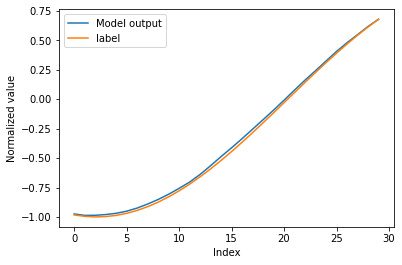

In [26]:
plt.plot(output[:pred_horizon], label='Model output')
plt.plot(label_test[:pred_horizon], label='label')


plt.ylabel('Normalized value')
plt.xlabel('Index')
plt.legend()
plt.show()

In [27]:
mean_squared_error(label_test, output)

0.0004086838000534798

## Check the attention values and shape

In [28]:
attention_weights = model.encoder_attention(src)[1]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights = attention_weights.reshape(src.shape[1], src.shape[1])

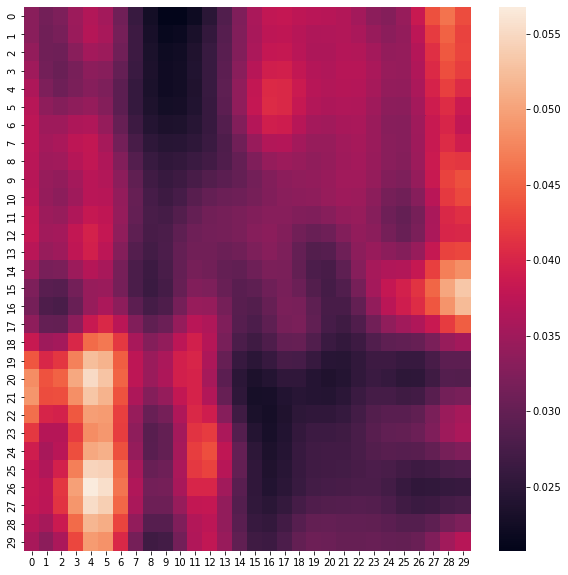

In [29]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(attention_weights)

In [30]:
df = {'row_idx':[],
      'col_idx':[],
      'value':[]}
for row_idx in range(attention_weights.shape[0]):
    for col_idx in range(attention_weights.shape[1]):
        df['row_idx'].append(row_idx)
        df['col_idx'].append(col_idx)
        df['value'].append(attention_weights[row_idx][col_idx])

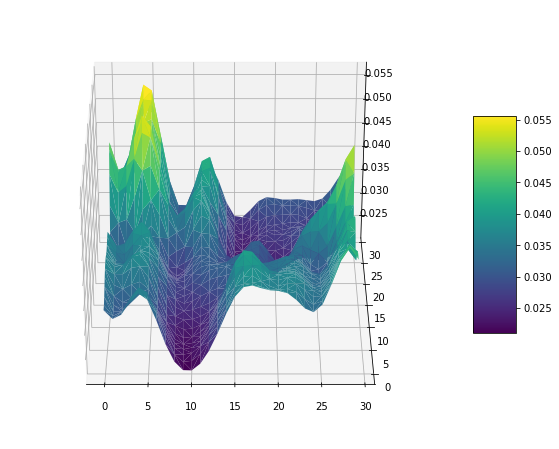

In [31]:
df = pd.DataFrame(df)
# Transform it to a long format
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# to Add a color bar which maps values to colors.
fig = plt.figure(figsize=(11, 8))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, -90)
plt.show()

### Decoder attention

### Self attention plot

In [32]:
self_att, src_tgt_att = model.decoder_attention((src, tgt_in))
attention_weights = self_att[1]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights = attention_weights.reshape(tgt_in.shape[1], tgt_in.shape[1])

In [33]:
df = {'row_idx':[],
      'col_idx':[],
      'value':[]}
for row_idx in range(attention_weights.shape[0]):
    for col_idx in range(attention_weights.shape[1]):
        df['row_idx'].append(row_idx)
        df['col_idx'].append(col_idx)
        df['value'].append(attention_weights[row_idx][col_idx])

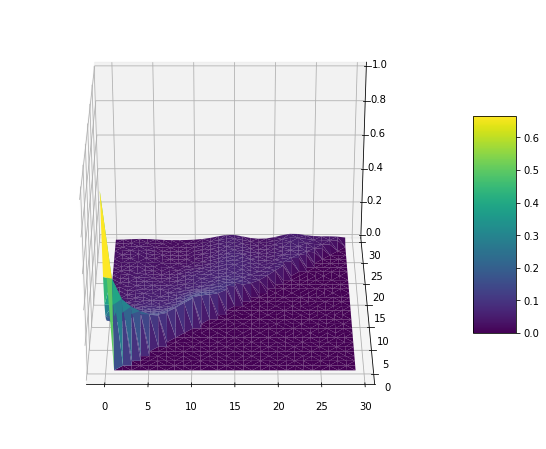

In [34]:
df = pd.DataFrame(df)
# Transform it to a long format
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# to Add a color bar which maps values to colors.
fig = plt.figure(figsize=(11, 8))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, -90)
plt.show()

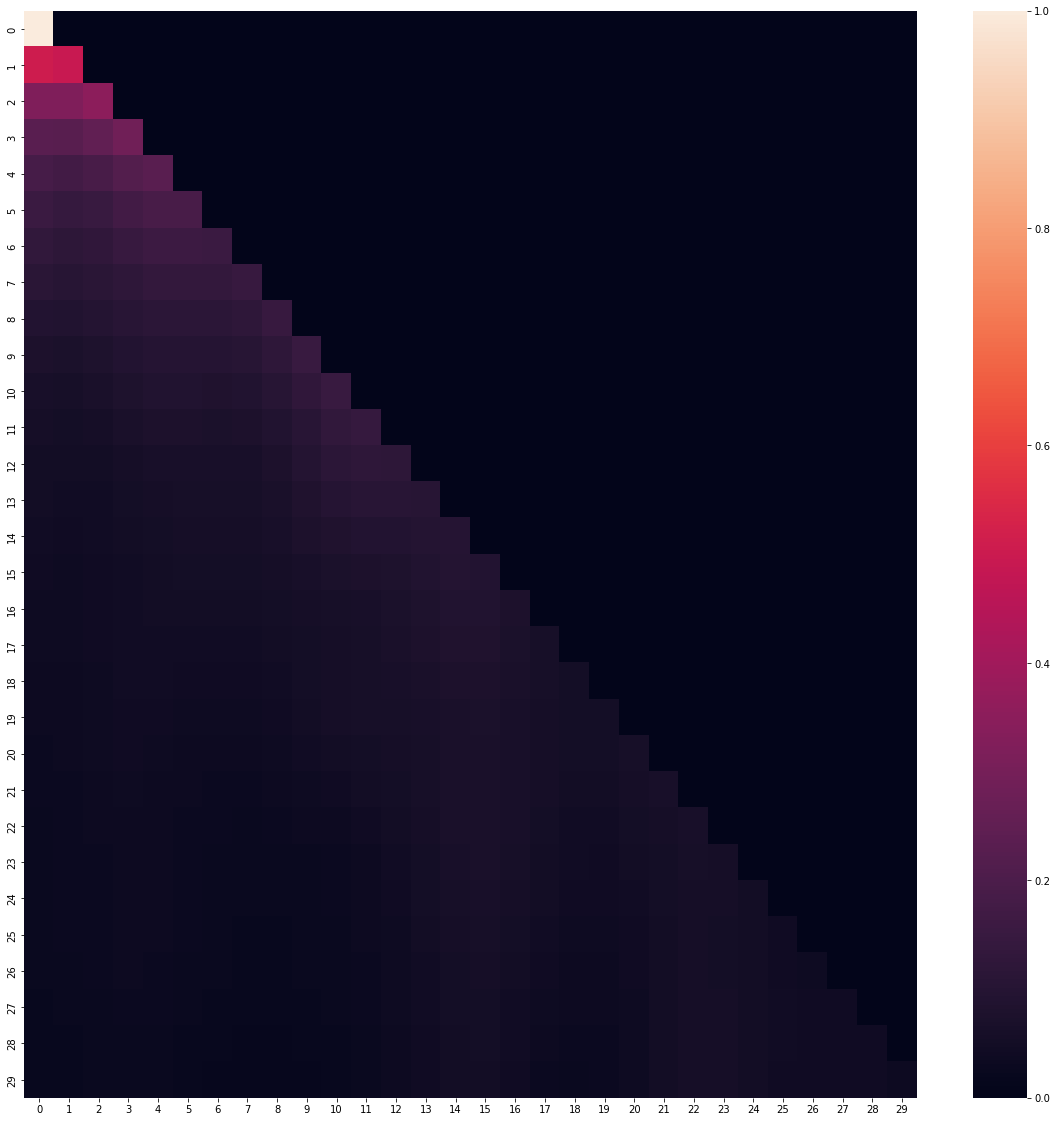

In [35]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(attention_weights)

In [36]:
attention_weights = src_tgt_att[1]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights = attention_weights.reshape(src.shape[1], tgt_in.shape[1])

In [37]:
df = {'row_idx':[],
      'col_idx':[],
      'value':[]}
for row_idx in range(attention_weights.shape[0]):
    for col_idx in range(attention_weights.shape[1]):
        df['row_idx'].append(row_idx)
        df['col_idx'].append(col_idx)
        df['value'].append(attention_weights[row_idx][col_idx])

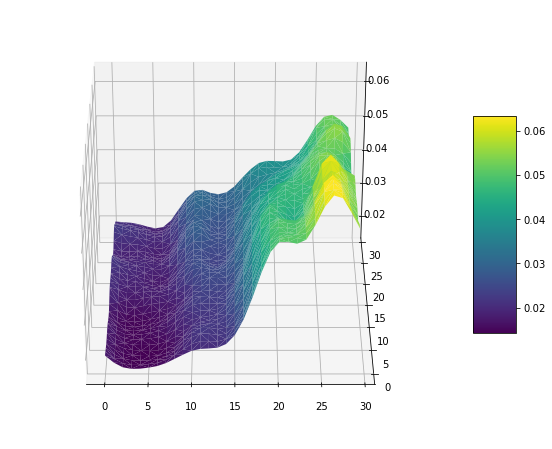

In [38]:
df = pd.DataFrame(df)
# Transform it to a long format
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# to Add a color bar which maps values to colors.
fig = plt.figure(figsize=(11, 8))
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.view_init(30, -90)
plt.show()

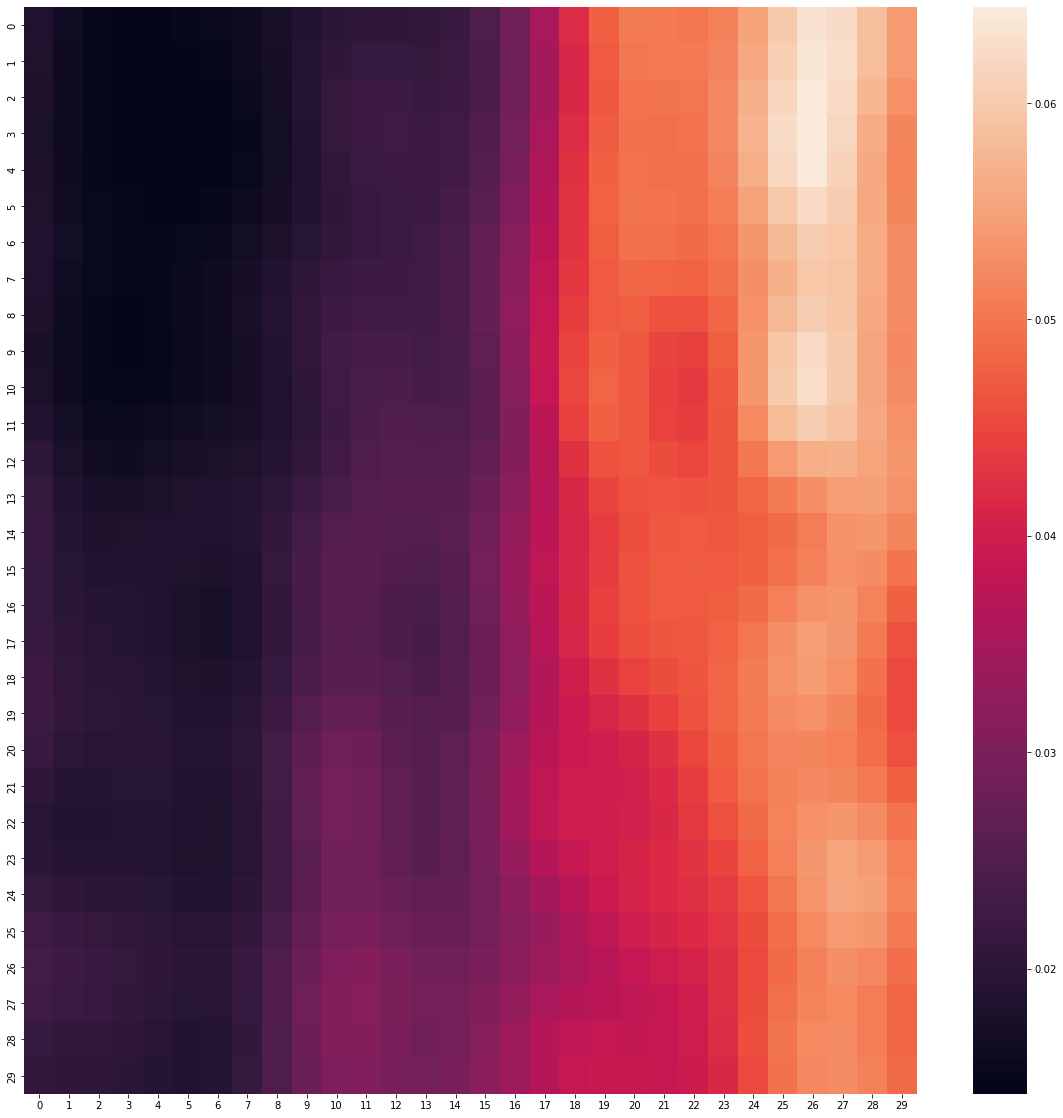

In [39]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(attention_weights)